# Decision Tree Classifier - Structure energy Correlations
### Authors: Pegah S. Mirabedini,  Code last modified on Feb, 2021
The main code is available via a GitHub repository: 

This code uses a dataset of 5000 configurations of water molecule on a photocatalytic surface. I generated the data using molecular dynamics simulations. The data is not published. However, it can be provided under request and with my advisor's permission. 

I have also attached a PDF version of the code and the results for more convenience. 


### Citrine's Questionary & Responses:
**● What problem do your contributions aim to solve?**
 In this code, I explored possible correlations between initial configuration of water molecule on a solid surface and the system's final energetic stability. 

**○ What approach did you use to solve the problem?**
For feature selection, we can consider either the coordinates of the water molecules, or the spatial angles of the molecule with respect to the surface. There are many more ways to construct the features, but these are the two I initially considered. I used the k-means clustering and decision tree classification models for clustering structures based on thei final energies and predict their thermodynamic stability. I used pandas for data preprocessing and scikit-learn to implement k-means clustering and decision tree algorithms.

**○ How does it work?**
Our goal is to define a classifier that can predict energy group of a molecule configuration on a slab surface.
steps to this end: 
<ol>
<li><b> Initial data analysis </b> check the features and how they relate to our target (energy) </li>
<li><b> configuration space computation </b> compute configurational space parameters </li>
<li><b> Kmeans clustering </b> to find clusters of energy. </li>
<li><b> Second data analysis </b> analyze the relation between configurational space and clusters of total energy. </li>
<li><b> Decision Tree Classifier </b> Train and test a decision tree model. </li>
</ol>


**● In what context did you write this code? For example, was it for a class project?**
As part of my thesis, I am investigating the mechanism for water splitting on photocatalytic surfaces. For this project, I am developing an approach that couples Bayesian inference and quantum simulations to accelerate computational studies of molecule-surface interactions. In this problem, we often deal with numerous choices in selecting the initial molecule configuration. The traditional method of finding the lowest energy structure is to perform and compare several possible simulations. Not only the traditional method requires performing many calculations, different simulations often converge at the same result, which is a waste of computational effort. To gain a better understanding of this problem, as part of this project, I analyzed the performance of other ML models, including Decision Tree (the presented code), and Neural Networks to predict the energy of a given initial configuration. To train and validate the ML models, I used a database of 5000 random configurations of a water molecule on the ZnO semi-polar surface and their energies after performing MD simulations. 

**● If this project was a collaboration:**

**○ Who else contributed?**
I fully wrote the presented code. The main project is supervised by my advisor, Dr. Alex greaney, and I also passed the machine learning trainings by kaggle.com which helped me with writing the code.

**○ In what capacity?**

**○ Which parts are yours? ○ Remember: we need a clear idea of exactly what your contributions were.**
I wrote all the code (except for the loadamesdata function), visualized, and analyzed the results. 

**● What do you find interesting, surprising, or special about your contributions to this project?**
Predicting the final stability of a molecule-sutface structural configuration is a hard problem due to dealing with many configurations with similar energies. Prior to this, I analyzed regressor models. Due to the mentioned problem, regressor models, such as decision tree regressor and neural networks were found to provide a poor prediction accuracy. Here, I show that using a classification approach, we can obtain an acceptable prediction (compare plots for actual data and predicted energies.) for the lower energy structures. I would like to note that although the predictions of this model is much better than the tested regressor model, the Bayesian approach still offers many advantages, including not needing a large dataset and quantifying the uncertainty value. Therefore, I am continuing my work on the Bayesian optimizer. 

**● What did you learn from this project?**
This project improved my data analytics skills and model optimization using pandas and scikit-learn.

**● If you were to rewrite your code, what would you do differently?**
I would try other methods of feature selection as well as other methods to evaluate the performance of the model, such as the confussion matrix and precision-recall plot. In addition, many parts of the code is repeating, for example for plotting purpose. I would define a function for these parts to avoid repetition.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.preprocessing import label_binarize

import matplotlib.pyplot as plt

## Initial data analysis

In [2]:
data = pd.read_csv("./water-init-pos-Ens.csv")
data.describe()

,Ox,Oy,Oz,H1x,H1y,H1z,H2x,H2y,H2z,Tot_En,Pot_En,vdW_En,Coul_En
count,5000.000000,5000.000000,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,10.520792,6.635305,1.791175e+01,10.518805,6.639893,18.235225,10.827397,6.582304,17.839640,-29755.696047,-29755.696047,5545.833563,-17117.997812
std,1.733909,1.747296,2.131841e-13,1.804560,1.817703,0.579350,1.824298,1.825966,0.509504,5.819200,5.819200,3.324072,9.812080
min,7.282674,3.413599,1.791175e+01,6.575044,2.598014,16.941782,6.705610,2.624129,16.942175,-29760.600950,-29760.600950,5534.534037,-17127.610320
25%,8.994789,5.128800,1.791175e+01,9.017850,5.138938,17.787476,9.314482,5.062087,17.452681,-29760.595090,-29760.595090,5542.669042,-17127.167690
50%,10.529294,6.625549,1.791175e+01,10.517507,6.599615,18.409923,10.837341,6.570393,17.766267,-29754.822920,-29754.822920,5546.206379,-17118.994785
75%,12.023183,8.129761,1.791175e+01,12.017871,8.156384,18.759721,12.340088,8.089157,18.232416,-29754.472530,-29754.472530,5549.188393,-17110.914675
max,13.733497,9.917321,1.791175e+01,14.544109,10.778851,18.881750,14.611802,10.843835,18.880993,-29717.741840,-29717.741840,5549.591784,-17070.831140


/Users/pmira002/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/pmira002/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/pmira002/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


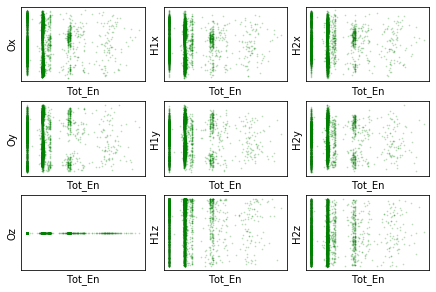

In [3]:
"""general data plot - x y z coordinate vs. total energy"""

nftoplot = 3
fig,axs = plt.subplots(nftoplot,nftoplot)
coords = ['Ox','Oy','Oz','H1x','H1y','H1z','H2x','H2y','H2z']

for i in range(nftoplot):
    for j in range(nftoplot):
        axs[i,j].plot(data['Tot_En'], data.iloc[:,i+3*j],'g.', alpha=.2, markersize=1.5)
        axs[i,j].set_xlabel('Tot_En')
        axs[i,j].set_ylabel(coords[i+3*j])
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        
fig.tight_layout(pad=.5)
plt.show()

## Configuration space computation

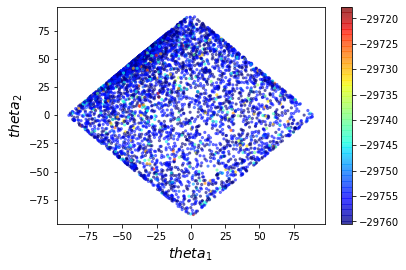

In [4]:
"""Compute configurational space:
   OH1 and OH2: matrices of shape (mx3) : OH bonds for all configurations in the dataset. 
   n_bonds: matrix of shape (mx3) of normal vectors to the plane passing from OH1 and OH2.
   n_surf: matrix of shape (mx3) of normal vectors to the adsorbate surface plane.
   theta1: matrix of shape (mx3) of angle between n_surf and OH2 for all configurations.
   theta2: matrix of shape (mx3) of angle between n_surf and n_bonds for all configurations.
   plot theta1 vs. theta2 and color with energy value"""

O = data.iloc[:,:3].values
H1 = data.iloc[:,3:6].values
H2 = data.iloc[:,6:9].values
energy = data.Tot_En.values

OH1 = H1 - O
OH2 = H2 - O
V2 = OH1 + OH2
n_bonds = [np.cross(OH1[i],OH2[i]) for i in range(len(OH1))] 
n_surf = [0,0,1] 
m = len(data.values)

theta1 = []
theta2 = []
rad2degree = 180/np.pi

for j in range(m):
    v1 = n_bonds[j]
    v2 = V2[j]
    v3 = np.cross(v1,v2)
    dot1 = np.dot(n_surf,v2)
    
    norm1 = (np.linalg.norm(n_surf)*np.linalg.norm(v2))
    theta1.append((np.arccos(dot1/norm1))*rad2degree - 90)
    dot2 = np.dot(n_surf,v3)
    norm2 = (np.linalg.norm(n_surf)*np.linalg.norm(v3))
    theta2.append((np.arccos(dot2/norm2))*rad2degree - 90)
    


#plot
_ = plt.scatter(theta1, theta2, c=np.array(energy),cmap='jet', alpha=.5, s=5)
plt.xlabel(('$theta_1$'),fontsize=14)
plt.ylabel('$theta_2$',fontsize=14)
plt.colorbar()
plt.show()

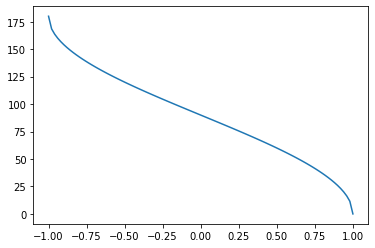

In [5]:
x = np.linspace(-1,1,100)
thx = np.arccos(x)*180/np.pi
plt.plot(x,thx)
plt.show()

## Kmeans clustering

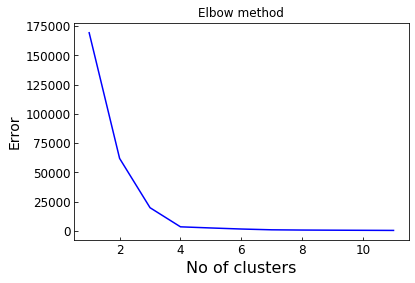

In [6]:
"""find k that minimizes error."""

y = energy[:,np.newaxis]

Err = []

for k in range(1,12):
    kmeans = KMeans(n_clusters=k, random_state=0)
    y_kmeans = kmeans.fit_predict(y)
    Err.append(kmeans.inertia_)

plt.plot(range(1,12),Err,'b')
plt.title('Elbow method',fontsize=12)
plt.xlabel('No of clusters',fontsize=16)
plt.ylabel('Error',fontsize=14)
plt.tick_params(direction='in',labelsize=12)
plt.show()

Cluster energies into 4 groups (k=4). Then plot angles again, but this time use clusters of energy for coloring.

In [7]:
kmeans4 = KMeans(n_clusters=4, random_state=0)
y_kmeans4 = kmeans4.fit_predict(y)

## Second data analysis

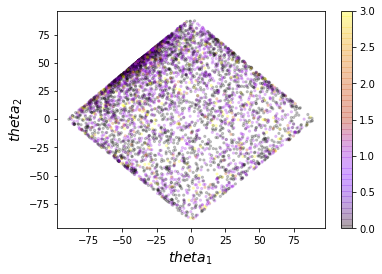

In [8]:
_ = plt.scatter(theta1, theta2, c=y_kmeans4, cmap='gnuplot', alpha=.2, s=5)
plt.xlabel(('$theta_1$'),fontsize=14)
plt.ylabel('$theta_2$',fontsize=14)
plt.colorbar()
plt.show()
#plt.savefig('./angles-clustered-feats.png',dpi=200)

5000


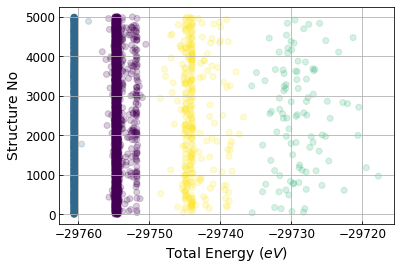

In [9]:
# plot of structural config. vs. final energetics 
Configs = np.arange(1,5001)
print(Configs[-1])
cmap = ['r','b','g','m']

plt.scatter(data.Tot_En,Configs,c=y_kmeans4,alpha=.2)
plt.xlabel(('Total Energy ('r'$eV$)'),fontsize=14)
plt.ylabel('Structure No',fontsize=14)
plt.tick_params(direction='in',labelsize=12)
plt.grid(None)
plt.show()

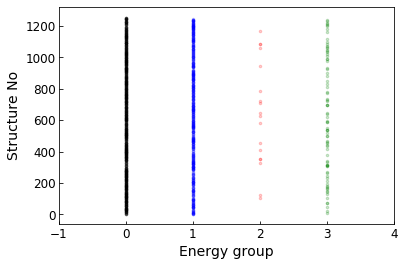

In [20]:
# plot of structural config. vs. group of final energetics 
plt.figure()
plt.xlim(-1,np.max(y_kmeans4)+1)
Configs = np.arange(0,1250)
bounds = [-29757, -29749.5, -29736]

cmap = ['k','b','r','g']
for i,y in enumerate(y_kmeans4[3750:]):
    plt.scatter(y, Configs[i], c=cmap[y], s=6.5, alpha=.2)

plt.xlabel(('Energy group'),fontsize=14)
plt.ylabel('Structure No',fontsize=14)
plt.tick_params(direction='in',labelsize=12)
plt.show()

## Decision Tree Classifier

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn import tree


def MyTree(train_X,val_X,train_y,val_y,randomstate=1,max_leaf_nodes=100):

    #define model
    Water_on_ZnO = DecisionTreeClassifier(max_leaf_nodes=max_leaf_nodes, random_state=1)

    #fit the model on the Train set
    Water_on_ZnO.fit(train_X,train_y)

    #Predict output for the validation set
    ypred = Water_on_ZnO.predict(val_X)

    #validate model - check error
    MAE = mean_absolute_error (val_y, ypred)
    #print("mean_absolute_error is {}".format(MAE))
    
    avg_Val_y = (data.Tot_En[5000-int(5000*0.25):]).mean()
    
    Rel_MAE = MAE/avg_Val_y
    print("The ratio of MAE to the avg En value in the validation set is {}". format(abs(MAE/avg_Val_y)))
    
    y_score = Water_on_ZnO.predict_proba(val_X)
    
    return MAE, Rel_MAE,ypred, y_score
    

if __name__=='__main__':
    
    features = coords
    X = data[coords]
    X2 = np.vstack((theta1,theta2)).T
    print(np.shape(X2))
    print(np.shape(X))
    yc = y_kmeans4

    train_X, val_X, train_y, val_y = train_test_split(X, yc, test_size=0.25, random_state=0)
    MAE, Rel_MAE,ypred,y_score = MyTree(train_X,val_X,train_y,val_y)
    print("mean_absolute_error using coord. as features is {}".format(MAE))
    
    train_X2, val_X2, train_y2, val_y2 = train_test_split(X2, yc, test_size=0.25, random_state=0)
    MAE2, Rel_MAE2,ypred2,y_score2 = MyTree(train_X2,val_X2,train_y2,val_y2)
    print("mean_absolute_error using angles as features is {}".format(MAE2))

(5000, 2)
(5000, 9)
The ratio of MAE to the avg En value in the validation set is 1.5082859740195078e-05
mean_absolute_error using coord. as features is 0.4488
The ratio of MAE to the avg En value in the validation set is 2.2180676088522174e-05
mean_absolute_error using angles as features is 0.66


the mean absolute error is lower when using the water molecule coordinates as features. Hereon, I use coordinates of the water molecule as features.

## Control Overfitting and Underfitting

In [16]:
def get_mae(train_X,train_y,val_X,val_y,max_leaf_nodes):
    
    Model = DecisionTreeClassifier(max_leaf_nodes=max_leaf_nodes,random_state=0)
    Model.fit(train_X,train_y)
    pred_vals = Model.predict(val_X)
    pred_val_train = Model.predict(train_X)
    mae_val = mean_absolute_error(val_y,pred_vals)
    mae_train = mean_absolute_error(train_y,pred_val_train)
    
    return mae_val, mae_train

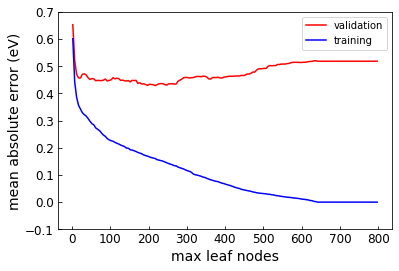

In [17]:
MAX_LEAF_NODES = range(2,800,5)
mae_val_list = []
mae_train_list = []

for max_leaf_nodes in MAX_LEAF_NODES:
    my_mae_val, my_mae_train = get_mae(train_X,train_y,val_X,val_y,max_leaf_nodes)
    #print("Max leaf nodes: %d  \t\t Mean Absolute validation Error:  %.3f" %(max_leaf_nodes, my_mae_val))
    #print("Max leaf nodes: %d  \t\t Mean Absolute training Error:  %.3f" %(max_leaf_nodes, my_mae_train))
    mae_val_list.append(my_mae_val)
    mae_train_list.append(my_mae_train)


#plot
_ = plt.plot(MAX_LEAF_NODES,mae_val_list,'r',label='validation')
_ = plt.plot(MAX_LEAF_NODES,mae_train_list,'b',label='training')
plt.xlabel('max leaf nodes',fontsize=14)
plt.ylabel('mean absolute error (eV)',fontsize=14)
plt.tick_params(direction='in',labelsize=12)
plt.ylim(-0.1,.7)
plt.legend()
plt.show()

In [18]:
mae_min = 10
best_tree_size = MAX_LEAF_NODES[0]

# find the ideal tree size from candidate_max_leaf_nodes
for max_leaf_nodes in MAX_LEAF_NODES:
    mae = get_mae(train_X,train_y,val_X,val_y,max_leaf_nodes)[0]
    if mae < mae_min:
        mae_min = mae
        best_tree_size = max_leaf_nodes

print(best_tree_size)


if __name__=='__main__':
    
    features = coords
    X = data[coords]
    yc = y_kmeans4

    train_X, val_X, train_y, val_y = train_test_split(X, yc, test_size=0.25, random_state=0)
    MAE, Rel_MAE,y_predict,y_score = MyTree(train_X,val_X,train_y,val_y,randomstate=1,
                                            max_leaf_nodes=best_tree_size)
    
    print("mean_absolute_error of the optimized tree using coord. as features is {}".format(MAE))

217
The ratio of MAE to the avg En value in the validation set is 1.4437603708528978e-05
mean_absolute_error of the optimized tree using coord. as features is 0.4296


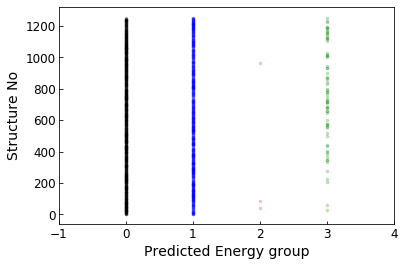

In [19]:
plt.figure()
plt.xlim(-1,np.max(y_predict)+1)
Configs = np.arange(0,1250)
bounds = [-29757, -29749.5, -29736]

cmap = ['k','b','r','g']
for i,y in enumerate(y_predict):
    plt.scatter(y, Configs[i], c=cmap[y], s=6.5, alpha=.2)

plt.xlabel(('Predicted Energy group'),fontsize=14)
plt.ylabel('Structure No',fontsize=14)
plt.tick_params(direction='in',labelsize=12)
plt.show()

We can see that the prediction is more accurate for the two lowest energy groups of data. However, for the other two energy groups, where the data is more sparsed, the model does not perform as well even after optimization.